# Train model to recognize **contrast loss** generated and original voice of same person **Generated Dataset** hyper_parameters


In [16]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [34]:
import librosa

from src.columns.generated_dataset_column import GeneratedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class GeneratedSoundDS(Dataset):
	def __init__(
		self,
		voiceDataset,
		original_voice_data_path,
		generated_voice_data_path,
		sample_rate=16000,
		duration=3,
		transform=None
	):
		self.voiceDataset = voiceDataset
		self.original_voice_data_path = str(original_voice_data_path)
		self.generated_voice_data_path = str(generated_voice_data_path)
		self.duration = duration
		self.sample_rate = sample_rate
		self.transform = None
		if transform is not None:
			self.transform = transform
		else:
			self.transform = CompositeTransformation(
				[
					ResampleTransform(target_sample_rate=sample_rate),
					CustomAdjustDurationTransform(duration_seconds=duration),
					ToMelSpectrogramTransform(
						sample_rate=sample_rate, n_mels=64, n_fft=512)
				]
			)

	def __len__(self):
		return len(self.voiceDataset)

	def _get_sgram(self, audio_file):
		audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
		spectrogram = self.transform.transform((audio, sample_rate))
		return spectrogram

	def _get_sample_path(self, path, source):
		data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
		return data_path + path

	def _get_label(self, label):
		return torch.tensor(1 if label else 0, dtype=torch.int64)

	def __getitem__(self, idx):
		anchor_path, posneg_path, _, _, anchor_source, posneg_source, label = self.voiceDataset.iloc[idx][
			[
				GeneratedDatasetColumn.ANCHOR_PATH,
				GeneratedDatasetColumn.POSNEG_PATH,
				GeneratedDatasetColumn.ANCHOR_ID,
				GeneratedDatasetColumn.POSNEG_ID,
				GeneratedDatasetColumn.SOURCE_ANCHOR,
				GeneratedDatasetColumn.SOURCE_POSNEG,
				GeneratedDatasetColumn.LABEL
			]
		].values.tolist()

		anchor_file = self._get_sample_path(anchor_path, anchor_source)
		posneg_file = self._get_sample_path(posneg_path, posneg_source)
		label = self._get_label(label)
		anchor_sgram = self._get_sgram(anchor_file)
		posneg_sgram = self._get_sgram(posneg_file)

		return anchor_sgram, posneg_sgram, label

In [35]:

DATASET_PATH = './dataset/'
DATA_PATH = './data/'
MODEL_SAVE_PATH = './model_save/'

In [36]:
class DS(GeneratedSoundDS):
	def _get_label(self, label):
		return torch.tensor(0 if label else 1, dtype=torch.int64)

In [37]:

DATASET_PATH = './dataset/'
DATA_PATH = './data/'
MODEL_SAVE_PATH = './model_save/'
SAMPLE_RATE = 16000

In [38]:
from numpy.typing import NDArray
import numpy as np
class AudioToTimeSeriesTransform:
    def __init__(
            self,
            n_fft,
            hop_len=None,
            win_length=None,
            top_db=80,
            normalize=False
    ):
        self.spectrogram = transforms.Spectrogram(
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_len,
        )
        self.amplitude_to_db = transforms.AmplitudeToDB(top_db=top_db)
        self.normalize = normalize

    def __call__(self, samples: NDArray[np.float32], _: int):
        samples = torch.from_numpy(samples)
        spec = self.spectrogram(samples)
        spec = self.amplitude_to_db(spec)
        spec = spec.permute(1, 0)
        spec = spec.squeeze(0)
        return (spec)

In [39]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

train_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
		AudioToTimeSeriesTransform(n_fft=512)
	]
)

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=0, max_shift=0),
		AudioToTimeSeriesTransform( n_fft=512)
	]
)

In [40]:
train_df = pd.read_csv(DATASET_PATH + "train_generated_dataset.csv")
train_ds = DS(train_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset.csv")
test_ds = DS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

In [41]:
import matplotlib.pyplot as plt
def plot_lstm(sample):
	def plot_spec(ax, spec, title):
		ax.set_title(title)
		ax.imshow(spec, origin="lower", aspect="auto")
		ax.invert_yaxis()
	fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
	posneg = "same voice"
	if not sample[2]:
		posneg = "other or generated vocie"
	plot_spec(axes[0], sample[0], title="Original")
	plot_spec(axes[1], sample[1], title=posneg)
	fig.tight_layout()

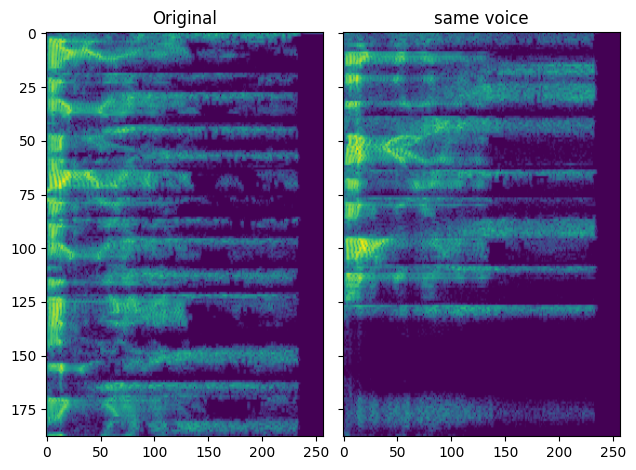

In [42]:
plot_lstm(train_ds[67])

In [43]:
class SiameseNetwork(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers):
		super(SiameseNetwork, self).__init__()
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.fc = nn.Linear(hidden_size, 512)

		self.final = nn.Linear(512, 2)

	def forward_once(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

	def forward(self, input1, input2):
		output1 = self.forward_once(input1)
		output2 = self.forward_once(input2)
		return output1, output2

In [44]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [45]:

import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm


def evaluate_siamese_model_contrast_loss(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
			loss = criterion(anchor_output, posneg_output, label)
			total_loss += loss.item()

			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss

In [28]:
def train_siamese_model_contrast_loss(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		optimizer.zero_grad()
		anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
		loss = criterion(anchor_output, posneg_output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		true_labels += [label.item() for label in label.cpu()]

	avg_loss = total_loss / len(dataloader)
	avg_loss = total_loss / len(dataloader)
	
	return avg_loss

In [29]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [46]:
num_epochs = 5
siamese_model = SiameseNetwork(input_size=257, hidden_size=512, num_layers=5).to('cuda')
criterion = ContrastiveLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
loss, accuracy, precision, recall, f1 = [], [], [], [], []
for epoch in range(num_epochs):
	_train_loss = train_siamese_model_contrast_loss(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}")
	_test_loss = evaluate_siamese_model_contrast_loss(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}")
	loss.append([_train_loss, _test_loss])

Epoch 1/5, Loss: 1.6721


Epoch 1/5, Loss: 1.8676


Epoch 2/5, Loss: 1.4772


Epoch 2/5, Loss: 1.5081


Epoch 3/5, Loss: 1.4568


Epoch 3/5, Loss: 1.4578


Epoch 4/5, Loss: 1.4294


Epoch 4/5, Loss: 1.3947


Epoch 5/5, Loss: 1.3450


Epoch 5/5, Loss: 1.3818


In [60]:
def save_model(model, model_name, base_path = './model_save/'):
	model.cpu()
	model.eval()
	torch.save(model, base_path + model_name)

In [61]:
save_model(siamese_model, "contrast_lstm.pt")

In [48]:
from matplotlib import pyplot as plt


def plot_siamese_model(anchor_sgram, posneg_sgram, label, loss):
	plt.style.use("dark_background")
	plt.figure(figsize=(10, 2), facecolor="#1e1e1e")
	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	type = "Positive" if label.item() == 0 else "Negative"
	plt.title(f"{type} Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.show()
	print(f"Similarity: {loss}")

In [49]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def evaluate(model, anchor_sgram, posneg_sgram, label):
	model.eval()
	model.to(device)
	with torch.no_grad():
		anchor_sgram = anchor_sgram.unsqueeze(0).to(device)
		posneg_sgram = posneg_sgram.unsqueeze(0).to(device)
		label = label.to(device)
		
		anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
		loss = torch.mean(F.pairwise_distance(anchor_output, posneg_output, keepdim = True))
	label.cpu()
	return loss.item()

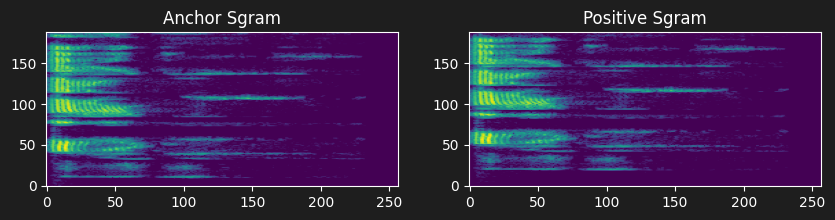

Similarity: 0.16804154217243195


In [50]:
anchor_sgram, posneg_sgram, label = train_ds[0]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)

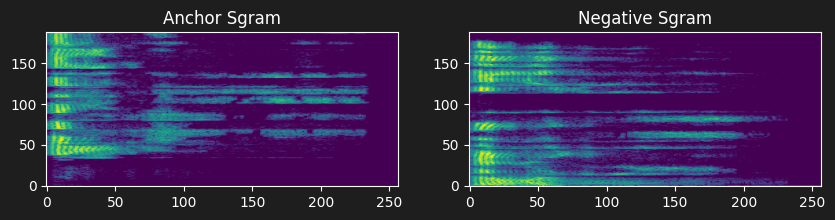

Similarity: 1.6823065280914307


In [51]:
anchor_sgram, posneg_sgram, label = train_ds[5]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)

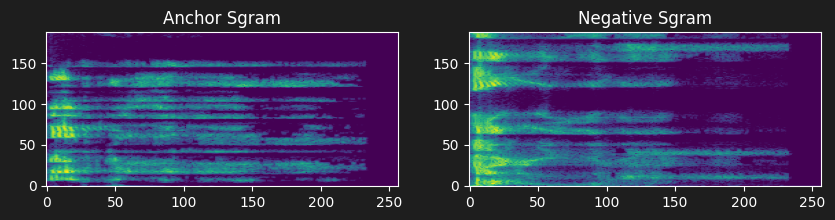

Similarity: 2.0427160263061523


In [52]:
anchor_sgram, posneg_sgram, label = test_ds[5]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)

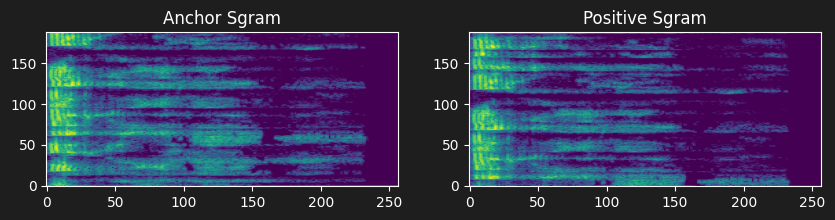

Similarity: 7.3588227678556e-05


In [66]:
anchor_sgram, posneg_sgram, label = test_ds[0]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def train_classifier(model, dataloader):
	model.eval()
	true_labels = []
	predicted_loss = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
			distances = torch.mean(F.pairwise_distance(anchor_output, posneg_output, keepdim = True), dim=1, keepdim=True)

			true_labels += [label.item() for label in label.cpu()]
			predicted_loss += [distance.item() for distance in distances.cpu()]

	return true_labels, predicted_loss

In [ ]:
X = np.array(predicted_loss).reshape(-1, 1)
y = np.array(true_labels)

In [ ]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression().fit(X, y)

In [ ]:
reg.score(X, y)